#### Retrieval for AI with Chroma and Mistral

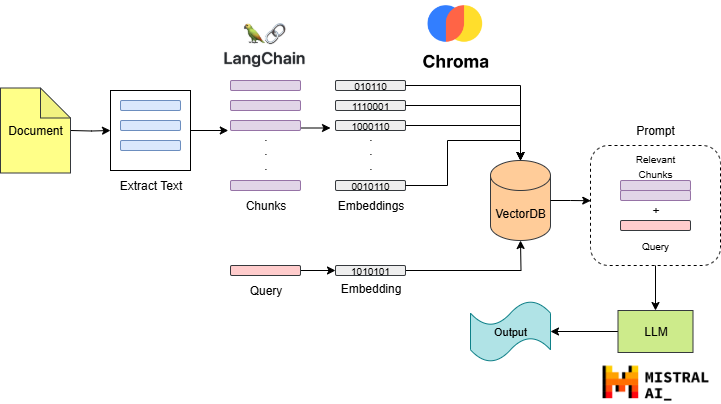

**Extract Text**

In [207]:
from pypdf import PdfReader

In [209]:
reader = PdfReader("microsoft_annual_report_2024.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages] # Read the page and extract text
pdf_texts = [text for text in pdf_texts if text] # Remove empty pages / texts

In [211]:
print(pdf_texts[0])

1 
Dear shareholders, colleagues, customers, and partners: 
Fiscal year 2024 was a pivotal year for Microsoft. We entered our 50th year as a company and the second year of the AI 
platform shift. With these milestones, I’ve found myself reflecting on how Microsoft has remained a consequential company 
decade after decade in an industry with no franchise value. And I realize that it’s because—time and time again, when tech 
paradigms have shifted —we have seized the opportunity to reinvent ourselves to stay relevant to our customers, our 
partners, and our employees. And that’s what we are doing again today.  
Microsoft has been a platform and tools company from the start. We were founded in 1975 with a belief in creating 
technology that would enable others to create their own. And, nearly 50 years later, this belief remains at the heart of our 
mission to empower every person and every organization on the planet to achieve more.   
This year, we moved from talking about AI to helping 

**Chunking**

In [213]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

In [215]:
# Recursively splits the text based on the separators
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

In [217]:
print(character_split_texts[10])
print(f"\nTotal chunks: {len(character_split_texts)}")

3 
staying in their flow and bringing the joy back to coding. This year, we also introduced Copilot Workspace, a Copilot -native 
developer environment, which helps any developer go from idea, to code, to software —all in natural language.  
We are also integrating generative AI across Power Platform, enabling anyone to use natural language to create apps, 
automate workflows, or build a website. In total, we now have 48  million monthly active users of Power Platform, up 
40 percent year-over-year.  
Modern work  
Microsoft 365 Copilot is becoming a daily habit for knowledge workers, transforming their work, workflow, and work artifacts. 
Adoption has been faster than any other new Microsoft 365 suite. And employees at nearly 60  percent of the Fortune 500 
now use Copilot to complete tasks faster, hold more effective meetings, and automate business workflows and processes.

Total chunks: 337


In [219]:
# Split text into chunks based on the token limits of Sentence Transformers models. Embedding models will have a context window (eg. 256)
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(token_split_texts[10])
print(f"\nTotal chunks: {len(token_split_texts)}")

3 staying in their flow and bringing the joy back to coding. this year, we also introduced copilot workspace, a copilot - native developer environment, which helps any developer go from idea, to code, to software — all in natural language. we are also integrating generative ai across power platform, enabling anyone to use natural language to create apps, automate workflows, or build a website. in total, we now have 48 million monthly active users of power platform, up 40 percent year - over - year. modern work microsoft 365 copilot is becoming a daily habit for knowledge workers, transforming their work, workflow, and work artifacts. adoption has been faster than any other new microsoft 365 suite. and employees at nearly 60 percent of the fortune 500 now use copilot to complete tasks faster, hold more effective meetings, and automate business workflows and processes.

Total chunks: 349


**ChromaDB**

In [221]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [223]:
embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]])) # This is a very long vector and it represents the 10th text chunk
print(f"Dimensions: {embedding_function([token_split_texts[10]])[0].shape}") # 384 dimensions

[array([-7.16159791e-02, -3.28083038e-02,  1.37579553e-02,  7.91880651e-04,
        3.34563963e-02, -7.69318687e-03,  2.78001912e-02,  5.27223805e-03,
        6.70650508e-03, -1.63349546e-02, -6.50985166e-02,  6.27819099e-05,
       -2.28739176e-02,  1.39710624e-02,  1.23192310e-01,  1.04662649e-01,
        1.33002205e-02, -8.84126052e-02, -1.78204407e-03, -6.06858321e-02,
       -3.33663002e-02, -8.00379459e-03, -1.39239877e-02, -1.57965086e-02,
        3.73077467e-02,  2.88191754e-02, -8.10246840e-02, -5.41278869e-02,
        6.50319755e-02,  2.74749775e-03, -7.52384439e-02,  7.96751603e-02,
        6.57480732e-02,  9.62239057e-02,  6.73093926e-03,  4.74736318e-02,
        1.18506858e-02,  4.03765813e-02, -5.42808510e-03, -6.85792640e-02,
       -3.73592079e-02, -3.53258997e-02, -1.71703082e-02,  3.49534489e-02,
        5.58741391e-02, -4.24483344e-02, -5.43241054e-02,  1.04429377e-02,
        3.09926402e-02,  9.08052847e-02, -6.71225116e-02, -9.28947031e-02,
        5.77814467e-02, 

In [225]:
# Setup chroma
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("microsoft_annual_report_2024", embedding_function=embedding_function)

# Assign ID for each chunk
ids = [str(i) for i in range(len(token_split_texts))]

# Add to chromaDB
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

349

**Get user query, embed it and retrieve similar documents**

In [227]:
query = "What was the total revenue?"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

print("Retrieved Documents:\n")
for document in retrieved_documents:
    print(document)
    print('\n')

Retrieved Documents:

72 note 13 — unearned revenue unearned revenue by segment was as follows : ( in millions ) june 30, 2024 2023 productivity and business processes $ 30, 879 $ 27, 572 intelligent cloud 23, 117 21, 563 more personal computing 6, 188 4, 678 total $ 60, 184 $ 53, 813 changes in unearned revenue were as follows : ( in millions ) year ended june 30, 2024 balance, beginning of period $ 53, 813 deferral of revenue 148, 701 recognition of unearned revenue ( 142, 330 ) balance, end of period $ 60, 184 revenue allocated to remaining performance obligations, which includes unearned revenue and amounts that will be invoiced and recognized as revenue in future periods, was $ 275 billion as of june 30, 2024, of which $ 269 billion is related to the commercial portion of revenue. we expect to recognize approximately 45 % of our total company remaining


80 no sales to an individual customer or country other than the united states accounted for more than 10 % of revenue for fiscal

**LLM**

In [229]:
import os
from dotenv import load_dotenv
from mistralai import Mistral

load_dotenv()

#  Get the key and set up the model
api_key = os.environ["MISTRAL_API_KEY"]
client = Mistral(api_key=api_key)

In [231]:
# Retrieval Prompt
def rag(query, retrieved_documents, client, model="mistral-small-latest"):
    information = "\n\n".join(retrieved_documents)

    messages = [{
        "role" : "system",
        "content" : """You are an expert financial research assistant.
        Your users are asking questions about information contained in an annual report.
        You will be shown the user's question, and the relevant information from the annual report.
        Answer the user's question using only this information."""
    },
    {
        "role" : "user",
        "content" : f"Question: {query}.\nInformation: {information}"
    }
    ]

    response = client.chat.complete(
        model = model,
        messages = messages
    )
    
    return response.choices[0].message.content

In [233]:
# Output
output = rag(query=query, retrieved_documents=retrieved_documents, client=client)
print(output)

The total revenue was $245,122 million.


**Visualization**

To visualize high-dimensional data into 2D/3D, we are going to use UMAP (Uniform Manifold Approximation and Projection). Unlike t-SNE and PCA, UMAP is faster and preserves the structure effectively.

In [ ]:
import umap
import numpy as np

embeddings = chroma_collection.get(include=['embeddings'])['embeddings'] # Get chroma embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings) # Fit embeddings

In [237]:
# Project embeddings in the  2D space
from tqdm import tqdm

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [239]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████████████████████████████████████████████████| 349/349 [00:01<00:00, 176.12it/s]


In [241]:
# For the user query, get the retrieved documents and its embeddings
query = "What is the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

query_embedding = embedding_function([query])[0] # Query embedding
retrieved_embeddings = results['embeddings'][0] # Retrieved document embeddings

# Project both embeddings
projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 172.54it/s]


(np.float64(3.0396360039710997),
 np.float64(14.563210380077361),
 np.float64(4.18370680809021),
 np.float64(10.196487855911254))

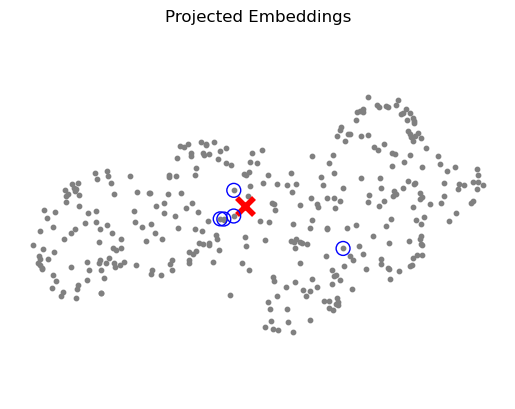

In [243]:
# Plot the projected query and retrieved documents in the embedding space
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, linewidths=4, marker='x', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='b')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'Projected Embeddings')
plt.axis('off')

#### Improvements - Query Expansion

Two types of query expansion:
1. User query --> LLM --> Hypothetical answer of that query --> User query + Hypothetical answer --> Retrieval System
2. User query --> LLM --> Multiple related queries --> User query + related queries --> Retrieval System

1. Expansion with **generated answers**

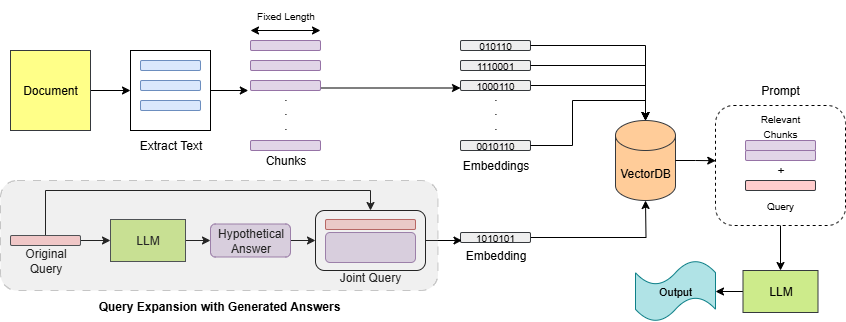

In [245]:
def augment_query_generated(query, model="mistral-small-latest"):
    messages = [
        {
            "role" : "system",
            "content" : "You are an expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report."
        },
        {
            "role" : "user",
            "content" : query
        }
    ]
    
    response = client.chat.complete(
        model = model,
        messages = messages
    )
    
    return response.choices[0].message.content    

In [247]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query) # LLM generated answer

joint_query = f"{original_query} {hypothetical_answer}" # Joint query = original query + hypo answer
print(joint_query)

Was there significant turnover in the executive team? **Example Answer:**

"During the fiscal year 2022, our organization experienced a moderate level of turnover within the executive team. Notably, we welcomed two new executives to our leadership team, while two long-serving executives transitioned out of their roles.

In the first quarter, we announced the appointment of [Name], who joined our company as Chief Technology Officer (CTO). [Name] brought with [him/her/their] extensive experience in digital transformation and innovation, succeeding [Previous Name], who retired after [number] years of dedicated service.

Additionally, in the third quarter, [Name] was appointed as our new Chief Financial Officer (CFO), replacing [Previous Name], who left to pursue other career opportunities. [Name] has a strong background in financial strategy and has been instrumental in driving our financial planning and analysis efforts.

While we regret the departure of our esteemed colleagues, we are c

In [249]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(doc)
    print('')

chief executive officer and director, gsk, plc board committees 1. audit committee 2. compensation committee 3. governance and nominating committee 4. environmental, social, and public policy committee executive officers satya nadella chairman and chief executive officer takeshi numoto executive vice president and chief marketing officer judson b. althoff executive vice president and chief commercial officer bradford l. smith vice chair and president kathleen t. hogan executive vice president and chief human resources officer christopher d. young executive vice president, business development, strategy, and ventures amy e. hood executive vice president and chief financial officer

88 directors and executive officers of microsoft corporation directors satya nadella chairman and chief executive officer, microsoft corporation catherine macgregor 4 group chief executive officer, engie s. a. carlos a. rodriguez 1, 2 director, automatic data processing, inc. reid g. hoffman 4 partner, greylo

In [251]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query]) 
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 128.23it/s]


(np.float64(3.0396360039710997),
 np.float64(14.563210380077361),
 np.float64(4.18370680809021),
 np.float64(10.196487855911254))

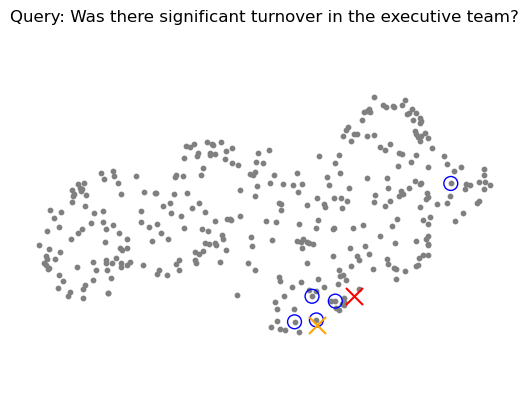

In [253]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='b')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='x', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='x', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'Query: {original_query}')
plt.axis('off')

Joint query (orange) is slightly shifted than original query (red) to match relevant documents.

2. Expansion with **multiple queries**

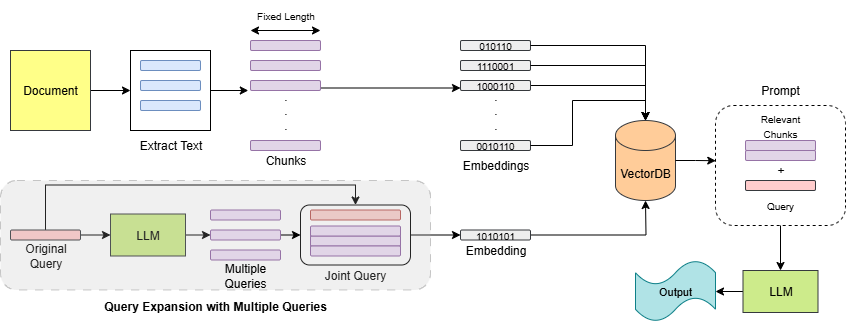

In [255]:
def augment_multiple_query(query, model="mistral-small-latest"):
    messages = [
        {
            "role" : "system",
            "content" : """You are a helpful expert financial research assistant. Your users are asking questions about an annual report.
            Suggest up to five additional related questions to help them find the information they need, for the provided question.
            Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic.
            Make sure they are complete questions, and that they are related to the original question.
            Output one question per line. Do not number the questions.
            """
        },
        {
            "role" : "user",
            "content" : query
        }
    ]
    
    response = client.chat.complete(
        model = model,
        messages = messages
    )

    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [257]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

What were the main revenue streams?
Which segments performed best?
Did new products or services drive growth?
Were there any significant market expansions?
How did pricing strategies impact revenue?


In [259]:
queries = [original_query] + augmented_queries # join all queries together
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# For each query, the system will retrieve 5 documents
# These documents maybe same, hence deduplicate before forming the prompt
# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(doc)
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
and services revenue increased 50 % driven by 44 points of net impact from the activision blizzard acquisition. xbox hardware revenue decreased 13 % driven by lower volume of consoles sold. • search and news advertising revenue increased $ 418 million or 3 %. search and news advertising revenue excluding traffic acquisition costs increased 12 % driven by higher search volume. • devices revenue decreased $ 815 million or 15 %. operating income increased $ 2. 9 billion or 17 %. • gross margin increased $ 6. 8 billion or 23 % driven by growth in gaming, with 10 points of net impact from the activision blizzard acquisition, as well as growth in windows. gross margin percentage increased driven by sales mix shift to higher margin businesses and improvement in devices. • operating expenses increased $ 3. 9 billion or 31 % driven by gaming, with 34 points of growth from the activision blizzard acqu

In [261]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 178.84it/s]


(np.float64(3.0396360039710997),
 np.float64(14.563210380077361),
 np.float64(4.18370680809021),
 np.float64(10.196487855911254))

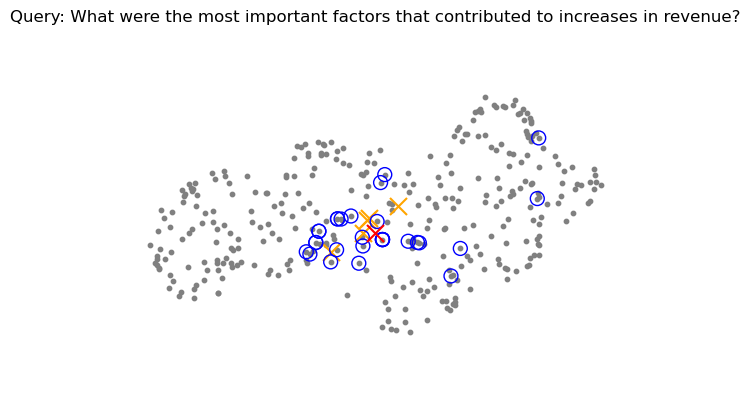

In [263]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='x', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='b')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='x', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'Query: {original_query}')
plt.axis('off')

Red - Original query. Orange - Similar augmented queries. Blue - nearest neighbors for each query in the embedding space.

#### Cross-encoder Re-ranking

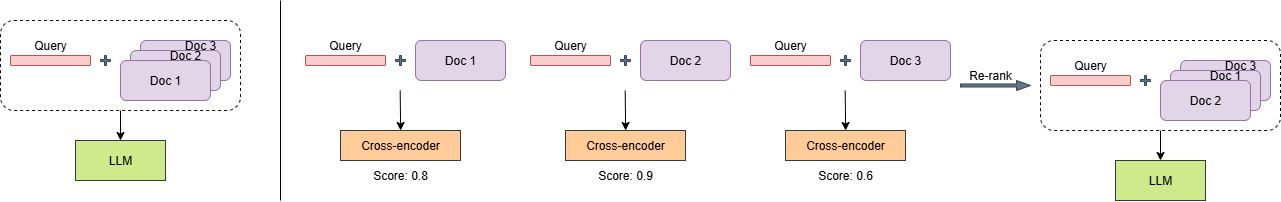

Given a query, the system retrieves n relevant documents. These relevant documents are retrieved based on the cosine similarity and they have no particular order when feeding it to the LLM. Cross-encoder helps re-rank the documents based on their relevancy to the query. Each retrieved document and query is paired and sent to cross-encoder for classification. The cross-encoder provides a relevancy score and based on the score the retrieved documents are re-ranked.

For example, retrieved documents are 1, 2, 3. The most relevant document to the query is, let's say 2, cross-encoder re-ranks the order of the documents as 2, 1, 3 and feed this to LLM. So LLM can provide effective answers to user query.

In [265]:
query = "What has been the investment in research and development?"

# Retrieve 10 relevant documents
results = chroma_collection.query(query_texts=query, n_results=10, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

22 investing in the future our success is based on our ability to create new and compelling products, services, and experiences for our users, to initiate and embrace disruptive technology trends, to enter new geographic and product markets, and to drive broad adoption of our products and services. we invest in a range of emerging technology trends and breakthroughs that we believe offer significant opportunities to deliver value to our customers and growth for the company. based on our assessment of key technology trends, we maintai n our long - term commitment to research and development across a wide spectrum of technologies, tools, and platforms spanning digital work and life experiences, cloud computing, ai, devices, and operating systems. while our main product research and development facilities are located in redmond, washington, we also operate research

33 operating expenses research and development ( in millions, except percentages ) 2024 2023 percentage change research and 

In [267]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [269]:
# For each doc in retrieved documents, create a pair with the query
pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs) # Cross-encoder classifies the pair and provides a score

print("Scores:")
for score in scores:
    print(score)

Scores:
1.2073865
-1.343805
-4.4759884
-8.112978
-10.512289
-10.067324
-6.2867923
-9.221193
-7.225221
-10.812669


Most relevant document is doc 1, then doc 2, then doc 3, then 7 and so on.

In [271]:
# Re-ranking
print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o+1)

New Ordering:
1
2
3
7
9
4
8
6
5
10


Now, the retrieved documents have been re-ordered. This is sent to LLM for final answer.

**Re-ranking with Query Expansion**

In [273]:
original_query = "What were the most important factors that contributed to increases in revenue?"
generated_queries = [
    "What were the main revenue streams?"
    "Which segments performed best?"
    "Did new products or services drive growth?"
    "Were there any significant market expansions?"
    "How did pricing strategies impact revenue?"
]

In [275]:
queries = [original_query] + generated_queries

results = chroma_collection.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [277]:
# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

unique_documents = list(unique_documents)

In [279]:
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

In [281]:
scores = cross_encoder.predict(pairs)
print("Scores:")
for score in scores:
    print(score)

Scores:
-8.943478
-3.9453428
-10.091204
-8.987711
-4.579033
-9.943016
-10.006309
-4.7935667
-4.048521
-7.5471067
-4.940128
-10.184122
-7.3813686


In [283]:
print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o)

New Ordering:
1
8
4
7
10
12
9
0
3
5
6
2
11


Now, the retrieved documents have been re-ordered. This is sent to LLM for final answer.